# King County Housing analysis

## Getting started and Preparing Data

### Imports

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#import descartes as dc
#import geopandas as gpd
#from shapely.geometry import Point, polygon


%matplotlib inline
plt.style.use('seaborn')
np.random.seed(42)

### Load Data

In [92]:
kc = pd.read_csv('King_County_House_prices_dataset.csv')
kc_backup = kc

In [3]:
kc.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

In [64]:
missing = pd.DataFrame(kc.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/kc.shape[0]*100,1)
missing[missing.Number!=0]

Number  Percentage
waterfront      2376        11.0
view              63         0.3
yr_renovated    3842        17.8

In [14]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  int64  
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [18]:
kc.nunique()

id               21420
date                 1
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      303
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

### replace missing value indicator '?' with 'NaN'

In [93]:
kc.replace(to_replace=['?', ''], value='NaN', inplace=True)

In [94]:
kc.sqft_basement = kc.sqft_basement.astype(float)

### change date to ordinal

In [67]:
kc['date'] = pd.to_datetime(kc['date'])
kc['date']=kc['date'].map(dt.datetime.toordinal)

### scale data

In [81]:
def scaling(scalee, scale_max = 100):
    scalee =  [f * scale_max / max(scalee) for f in scalee]
    
    return scalee
    

In [82]:
kc.bathrooms = scaling(list(kc.bathrooms))

kc.bathrooms.median()

28.125

In [86]:
kc[continuous_var] = scaler.fit_transform(kc[continuous_var])

### add dummy variables

In [36]:
continuous_var = list(kc.select_dtypes(
                        ['int64','float64','bool']).columns.values)
continuous_var.remove('id')
continuous_var.remove('waterfront')
categorical_var=['waterfront']
continuous_var

['date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

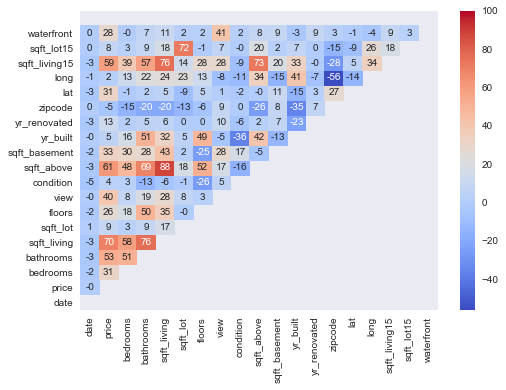

In [87]:
kc_dum=pd.get_dummies(kc[continuous_var+categorical_var].copy())
mask = np.triu(kc_dum.corr())
ax = sns.heatmap(round(kc_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')
ax.set_ylim((0,20))
plt.savefig('figures/correlogram.png')

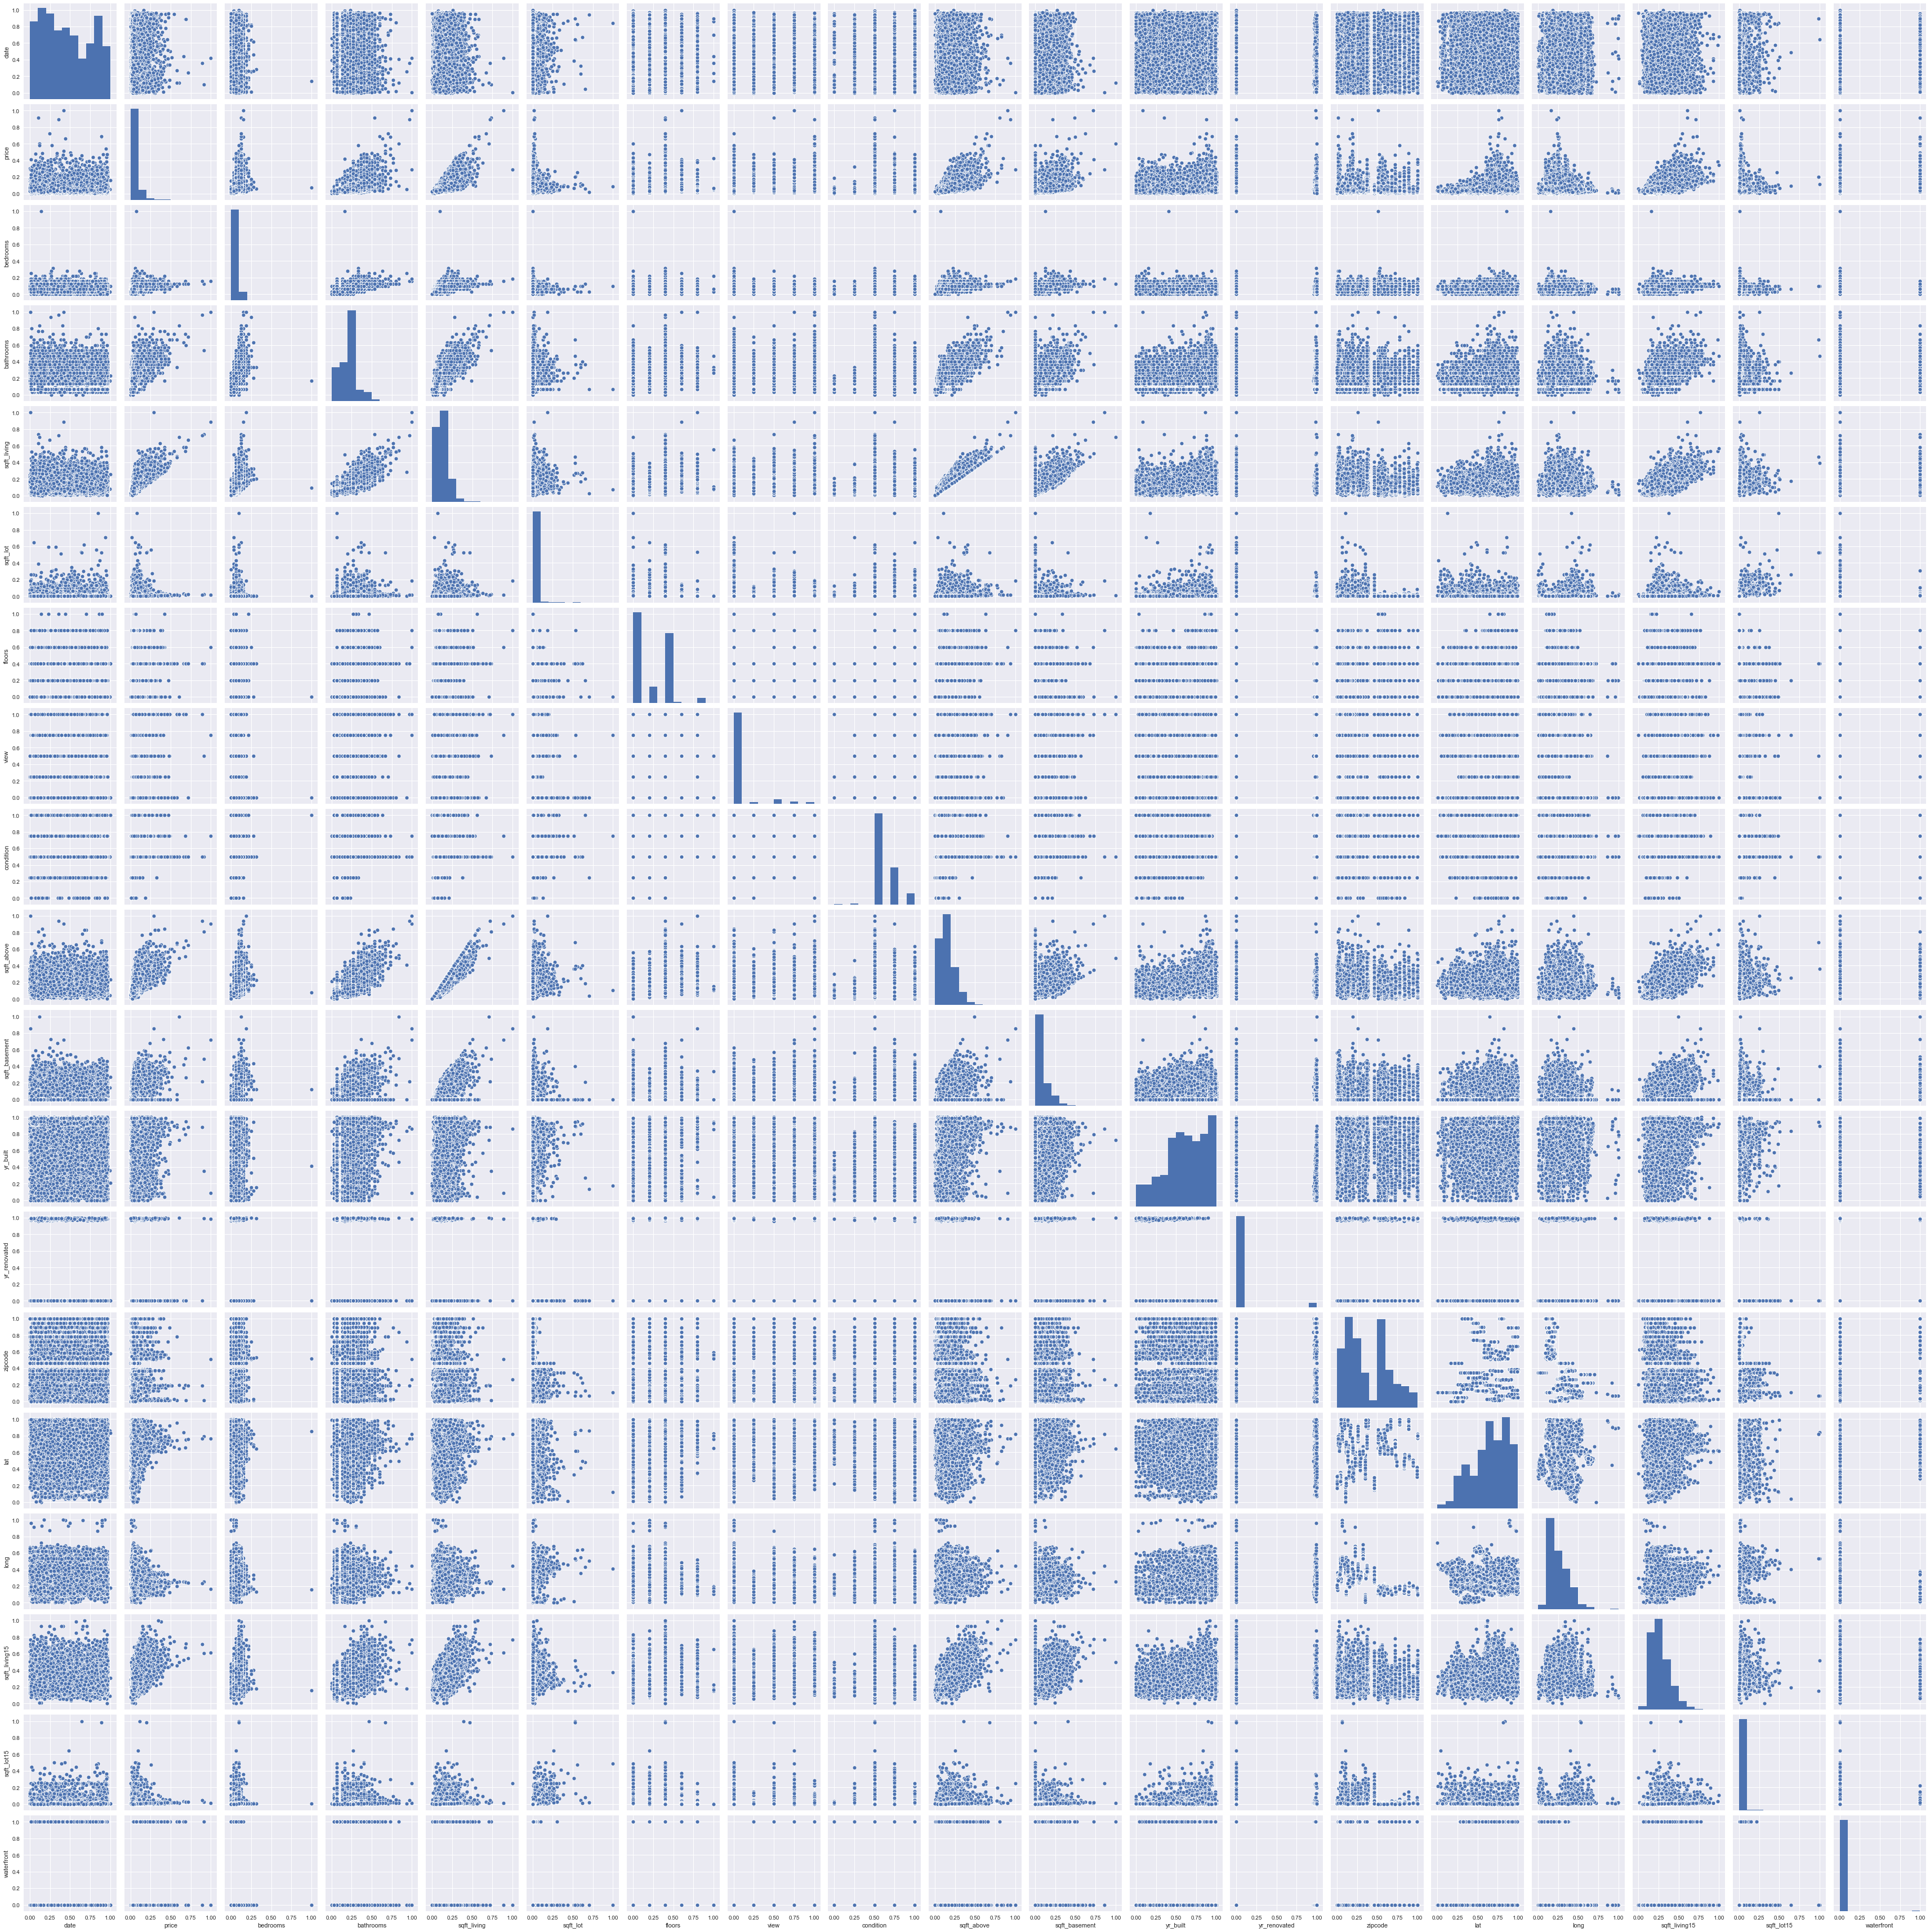

In [88]:
_ =sns.pairplot(kc_dum)
plt.savefig('figures/pairplot.png')

In [89]:
grade_cov = continuous_var
grade_cav = categorical_var

In [39]:
cov = grade_cov
cav = grade_cav

dsf = ' + '.join(list(cov)) + ' + ' + ' + '.join(list(cav))
dsf

'date + price + bedrooms + bathrooms + sqft_living + sqft_lot + floors + view + condition + sqft_above + sqft_basement + yr_built + yr_renovated + zipcode + lat + long + sqft_living15 + sqft_lot15 + waterfront'

In [91]:
kc.head()

id      date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7129300520  0.420513  0.018880   0.06250   0.066667     0.061503  0.003108   
1  6414100192  0.566667  0.060352   0.06250   0.233333     0.167046  0.004072   
2  5631500400  0.766667  0.013382   0.03125   0.066667     0.030372  0.005743   
3  2487200875  0.566667  0.069011   0.09375   0.333333     0.120729  0.002714   
4  1954400510  0.748718  0.056678   0.06250   0.200000     0.099468  0.004579   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     0.0         NaN   0.0  ...      7    0.089602       0.000000  0.478261   
1     0.4         0.0   0.0  ...      7    0.199115       0.082988  0.443478   
2     0.0         0.0   0.0  ...      6    0.044248       0.000000  0.286957   
3     0.0         0.0   0.0  ...      7    0.075221       0.188797  0.565217   
4     0.0         0.0   0.0  ...      8    0.144912       0.000000  0.756522   

   yr_renovated   zipcode       lat      long  sqft_living15  sqft_lot15  
0      0.000000  0.893939  0.571498  0.217608       0.161934    0.005742  
1      0.988089  0.626263  0.908959  0.166113       0.222165    0.008027  
2           NaN  0.136364  0.936143  0.237542       0.399415    0.008513  
3      0.000000  0.681818  0.586939  0.104651       0.165376    0.004996  
4      0.000000  0.368687  0.741354  0.393688       0.241094    0.007871  

[5 rows x 21 columns]

In [90]:
y = 'grade'
dsf = '''date + 
         price + 
         bedrooms + 
         bathrooms + 
         sqft_living + 
         floors + 
         view + 
         sqft_above + 
         yr_built + 
         yr_renovated + 
         lat + 
         long + 
         sqft_living15 + 
         waterfront'''

ols_formula = f'{y} ~ + {dsf}'
smf.ols(formula=ols_formula, data = kc).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  grade   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     3091.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:10:33   Log-Likelihood:                -14457.
No. Observations:               15762   AIC:                         2.894e+04
Df Residuals:                   15747   BIC:                         2.906e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.4035      0.027    202.952      0.000       5.351       5.456
date             -0.0637      0.017     -3.817      0.000      -0.096      -0.031
price             6.3839      0.172     37.194      0.000       6.047       6.720
bedrooms         -2.3831      0.211    -11.300      0.000      -2.797      -1.970
bathrooms         0.5271      0.086      6.106      0.000       0.358       0.696
sqft_living       2.8554      0.206     13.865      0.000       2.452       3.259
floors            0.3235      0.031     10.318      0.000       0.262       0.385
view              0.1229      0.031      4.022      0.000       0.063       0.183
sqft_above        2.1144      0.137     15.458      0.000       1.846       2.383
yr_built          1.0413      0.027     37.998      0.000       0.988       1.095
yr_renovated      0.0840      0.026      3.259      0.001       0.033       0.135
lat               0.1415      0.024      5.859      0.000       0.094       0.189
long             -0.8550      0.049    -17.402      0.000      -0.951      -0.759
sqft_living15     2.4565      0.068     36.189      0.000       2.323       2.590
waterfront       -0.7490      0.063    -11.977      0.000      -0.872      -0.626
==============================================================================
Omnibus:                      824.654   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2563.532
Skew:                          -0.219   Prob(JB):                         0.00
Kurtosis:                       4.926   Cond. No.                         79.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
price_cov = continuous_var
price_cav = categorical_var

In [95]:
price_cov.remove('long')

In [97]:
price_cov.remove('bedrooms')

In [101]:
price_cov.remove('condition')

In [102]:
y = 'long'
cov = price_cov
cav = price_cav

dsf = ' + '.join(list(cov)) + ' + ' + ' + '.join(list(cav))
ols_formula = f'{y} ~ + {dsf}'
smf.ols(formula=ols_formula, data = kc).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   long   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     1032.
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:52:30   Log-Likelihood:                 12938.
No. Observations:               15429   AIC:                        -2.585e+04
Df Residuals:                   15416   BIC:                        -2.575e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -20.7429      1.740    -11.922      0.000     -24.153     -17.332
bathrooms        -0.0113      0.002     -5.948      0.000      -0.015      -0.008
sqft_living    3.413e-06    1.3e-06      2.633      0.008    8.72e-07    5.95e-06
view             -0.0069      0.001     -5.213      0.000      -0.009      -0.004
grade            -0.0278      0.001    -21.375      0.000      -0.030      -0.025
sqft_above     2.466e-05   1.24e-06     19.829      0.000    2.22e-05    2.71e-05
sqft_basement -2.125e-05   1.43e-06    -14.842      0.000   -2.41e-05   -1.84e-05
yr_built          0.0012   3.95e-05     30.619      0.000       0.001       0.001
yr_renovated   8.721e-06   2.23e-06      3.903      0.000    4.34e-06    1.31e-05
zipcode          -0.0011    1.8e-05    -59.929      0.000      -0.001      -0.001
lat               0.0473      0.007      7.239      0.000       0.035       0.060
sqft_living15  4.453e-05   2.08e-06     21.389      0.000    4.05e-05    4.86e-05
sqft_lot15     7.462e-07   3.13e-08     23.826      0.000    6.85e-07    8.08e-07
waterfront       -0.0285      0.011     -2.664      0.008      -0.050      -0.008
==============================================================================
Omnibus:                     3001.052   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14039.063
Skew:                           0.875   Prob(JB):                         0.00
Kurtosis:                       7.333   Cond. No.                     5.69e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.67e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [107]:
df = pd.pivot_table(data = kc,
                    index = 'lat',
                    columns = 'long',
                    values = 'bedrooms')

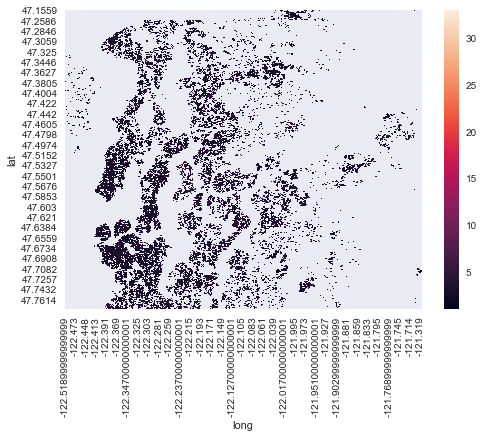

In [108]:
ax = sns.heatmap(df)